<a href="https://colab.research.google.com/github/Giandonn/data-science/blob/main/Trabalho_Salarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   

  company_location company_size  
0               ES            L  
1               US

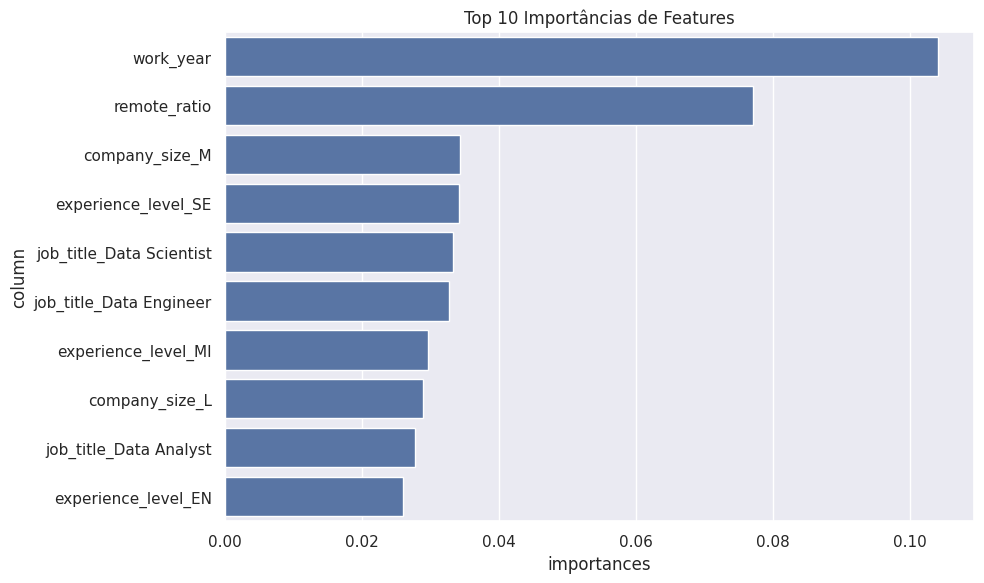

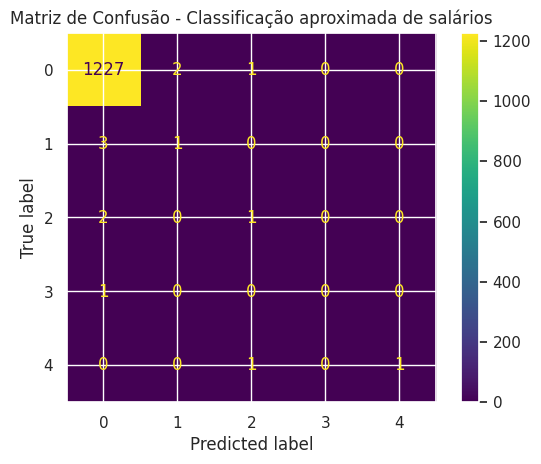

 10%|==                  | 77372/802280 [20:11<189:06]       

In [ ]:
import string
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import shap

pd.options.display.max_columns = None
sns.set_theme()

# Carregamento e visualização do dataset
df = pd.read_csv("/content/sample_data/ds_salaries.csv")
df.shape
print(df.head())

# Seleciona a variável alvo e features
TARGET = "salary"

# Define colunas categóricas para OneHotEncoding
ohe_cat = [
    "experience_level",
    "employment_type",
    "job_title",
    "employee_residence",
    "company_location",
    "company_size"
]

# Aplica OneHotEncoding
enc = OneHotEncoder(sparse_output=False)
ohe_encoded = enc.fit_transform(df[ohe_cat])
ohe_cols = enc.get_feature_names_out(ohe_cat)
ohe_df = pd.DataFrame(ohe_encoded, columns=ohe_cols)

# Concatena com as features numéricas
num_cols = ["work_year", "remote_ratio"]
x = pd.concat([df[num_cols].reset_index(drop=True), ohe_df], axis=1)
y = df[TARGET]

# Split dos dados
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print(x_train.shape, x_test.shape)

# Modelos base para comparação
estimators = [
    LogisticRegression(random_state=42, max_iter=500),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    LinearSVC(random_state=42, max_iter=10000)
]

for estim in estimators:
    estim.fit(x_train, y_train)
    y_pred = estim.predict(x_test)
    acc = accuracy_score(y_test, y_pred.round())  # arredonda pois alvo é contínuo
    print(type(estim).__name__, "Accuracy:", acc)

# Hiperparâmetros para RandomForest
parameters = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'max_features': ["sqrt", "log2"]
}
estim = RandomForestClassifier(random_state=42)
gscv = GridSearchCV(estim, parameters, scoring='r2')
gscv.fit(x_train, y_train)

best_rf = gscv.best_estimator_
best_rf.fit(x_train, y_train)
y_pred = best_rf.predict(x_test)
acc = accuracy_score(y_test, y_pred.round())
print("Best RandomForest Accuracy:", acc)

# Importância das features
imp = pd.DataFrame({"column": x.columns, "importances": best_rf.feature_importances_})
imp.sort_values(by="importances", ascending=False, inplace=True)
print(imp.head())

# Gráfico de importância
top_feats = imp.head(10)
plt.figure(figsize=(10,6))
sns.barplot(x="importances", y="column", data=top_feats)
plt.title("Top 10 Importâncias de Features")
plt.tight_layout()
plt.show()

y_pred_class = pd.cut(y_pred, bins=5, labels=False)
y_test_class = pd.cut(y_test, bins=5, labels=False)
cm = confusion_matrix(y_test_class, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matriz de Confusão - Classificação aproximada de salários")
plt.show()

explainer = shap.Explainer(best_rf, x_train)
shap_values = explainer(x_test)
shap.summary_plot(shap_values[:100], x_test.iloc[:100], feature_names=x_test.columns)